In [1]:
from google.colab import files
uploaded = files.upload()  # si le .zip n'est pas encore là


Saving gpt2-alchemy.zip to gpt2-alchemy.zip


In [2]:
!unzip gpt2-alchemy.zip


Archive:  gpt2-alchemy.zip
   creating: gpt2-alchemy/
  inflating: gpt2-alchemy/config.json  
  inflating: gpt2-alchemy/special_tokens_map.json  
  inflating: gpt2-alchemy/tokenizer_config.json  
  inflating: gpt2-alchemy/generation_config.json  
  inflating: gpt2-alchemy/vocab.json  
  inflating: gpt2-alchemy/model.safetensors  
  inflating: gpt2-alchemy/merges.txt  


In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model = GPT2LMHeadModel.from_pretrained("gpt2-alchemy")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-alchemy")


In [4]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the saved model and tokenizer
model = GPT2LMHeadModel.from_pretrained("./gpt2-alchemy")
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2-alchemy")

# Generate a sample
prompt = "the alchemist discovered a way to"
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(
    inputs['input_ids'],
    max_new_tokens=50,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.9
)
print("\n--- Generated Text ---")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- Generated Text ---
the alchemist discovered a way to convert the molecules of a food to the chemicals they take to create the substance. He called it the alchemist's concoction, and it has since become the standard beverage of modern Western culture. The name alchemy came from the ancient Greek word al


In [5]:
from google.colab import files
uploaded = files.upload()  # This will open a dialog to choose your CSV file


Saving alchtexts2_.csv to alchtexts2_.csv


In [31]:
import pandas as pd
import re

def load_and_clean_text(filepath):
    df = pd.read_csv(filepath)

    def clean_text(text):
        text = str(text).strip()
        text = re.sub(r'\d+', '', text)                                # Remove digits
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)            # Remove URLs
        text = re.sub(r'!\[.*?\]\(.*?\)', '', text)                    # Remove Markdown image links
        text = re.sub(r'[^\x00-\x7F]+', '', text)                      # Remove non-ASCII chars like √¢¬™
        text = re.sub(r'[^\w\s]', '', text)
        # Remove words like "unnumbered page" and "image"
        text = re.sub(r'\b(unnumbered page|image)\b', '', text)                           # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()                       # Normalize spaces
        return text.lower()

    df['cleaned'] = df['Text'].fillna("").apply(clean_text)
    return " ".join(df['cleaned'].tolist())

# Use it:
text = load_and_clean_text("alchtexts2_.csv")  # Replace with your file name


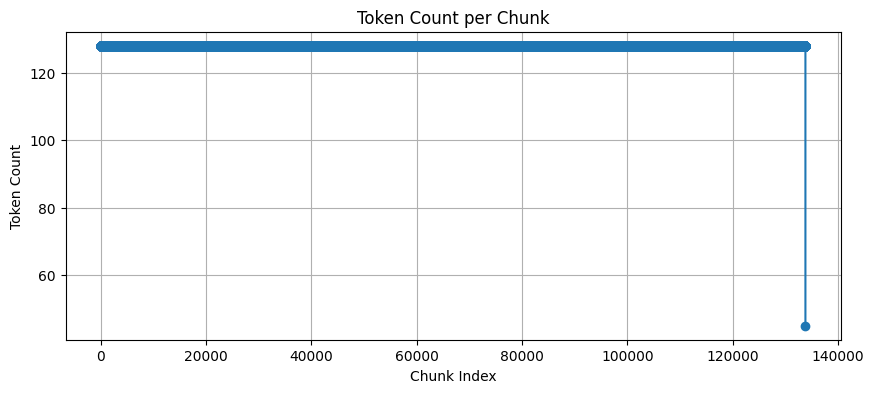

In [33]:
tokenized = tokenizer(text, return_tensors="pt", truncation=False)
lengths = [len(tokenized["input_ids"][0][i:i+128]) for i in range(0, len(tokenized["input_ids"][0]), 128)]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(lengths, marker='o')
plt.title("Token Count per Chunk")
plt.xlabel("Chunk Index")
plt.ylabel("Token Count")
plt.grid(True)
plt.show()



--- Token Chunk Statistics ---
count    1371.000000
mean      127.954048
std         1.701460
min        65.000000
25%       128.000000
50%       128.000000
75%       128.000000
max       128.000000
dtype: float64


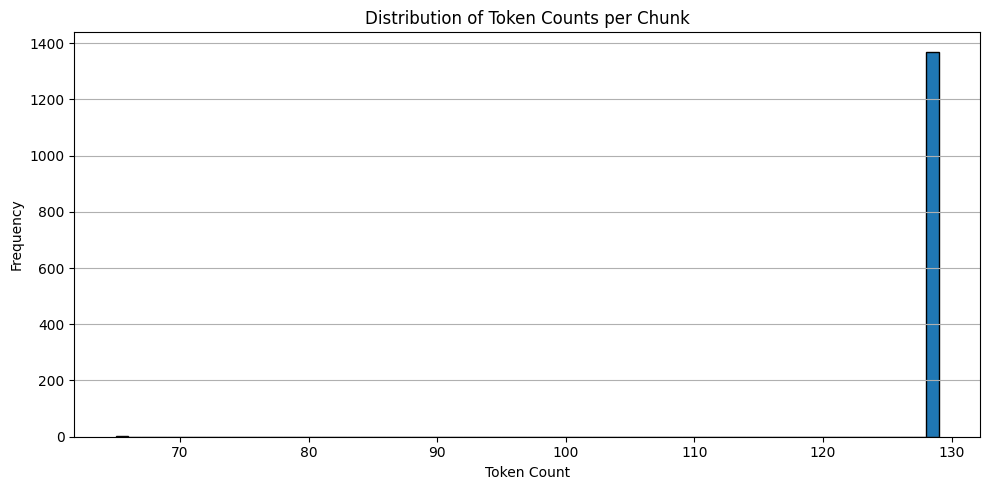

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Simulate the token count per chunk data (or use your actual `lengths`)
lengths = [128] * 1370 + [65]  # Replace with actual 'lengths' if you have them

# Basic statistics
lengths_series = pd.Series(lengths)
stats = lengths_series.describe()
print("\n--- Token Chunk Statistics ---")
print(stats)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=np.arange(min(lengths), max(lengths) + 2, 1), edgecolor='black')
plt.title("Distribution of Token Counts per Chunk")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


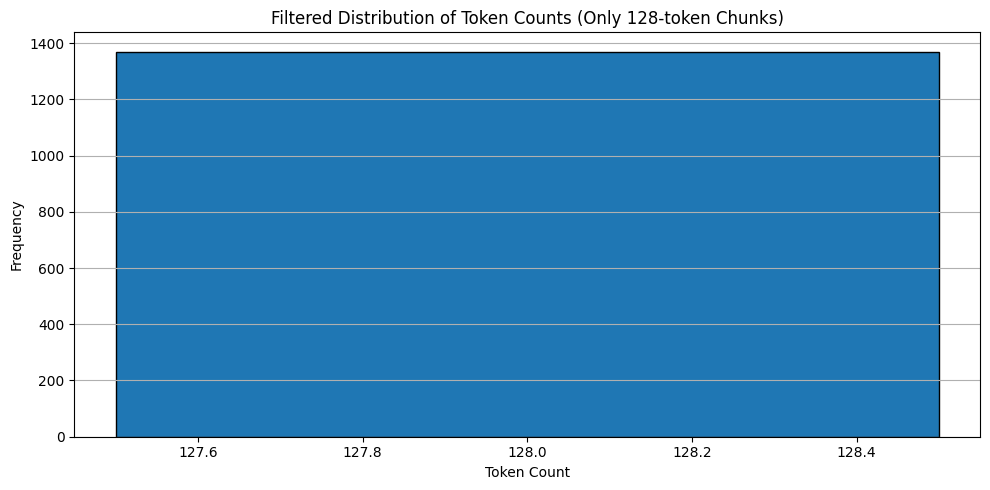


Filtered Stats (Only 128-token Chunks):

count    1370.0
mean      128.0
std         0.0
min       128.0
25%       128.0
50%       128.0
75%       128.0
max       128.0
dtype: float64


In [36]:
# Filter out chunks that are shorter than 128 tokens
filtered_lengths = [length for length in lengths if length == 128]

# Re-run the histogram
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(10, 5))
plt.hist(filtered_lengths, bins=np.arange(127.5, 129.5, 1), edgecolor='black')
plt.title("Filtered Distribution of Token Counts (Only 128-token Chunks)")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Statistics
stats_filtered = pd.Series(filtered_lengths).describe()
print("\nFiltered Stats (Only 128-token Chunks):\n")
print(stats_filtered)


In [37]:
# Split into chunks
chunks = [tokenized["input_ids"][0][i:i+128] for i in range(0, len(tokenized["input_ids"][0]), 128)]
chunks_128 = [chunk for chunk in chunks if len(chunk) == 128]

# Convert each chunk to text
chunk_texts = [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks_128]

# Save to CSV
import pandas as pd
df_chunks = pd.DataFrame({'Chunk': chunk_texts})
df_chunks.to_csv("clean_token_chunks.csv", index=False)


In [38]:
from google.colab import files
files.download("clean_token_chunks.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
from google.colab import files
uploaded = files.upload()


Saving clean_token_chunks.csv to clean_token_chunks (2).csv


In [40]:
import pandas as pd

df = pd.read_csv("clean_token_chunks.csv")  # Make sure it's uploaded
text = " ".join(df["Chunk"].dropna().tolist())  # Join all chunks into one text


In [41]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model = GPT2LMHeadModel.from_pretrained("./gpt2-alchemy")
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2-alchemy")


In [42]:
prompt = " ".join(text.split()[:40])  # Get first 40 words as a prompt

inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(
    inputs["input_ids"],
    max_new_tokens=50,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.9
)

print("\n--- Generated Text ---")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Generated Text ---
image unnumbered page the art of glass wherein are shown the wayes to make and colour glass pastes enamels lakes and other curiosities written in italian by antonio neri and translated into english with some observations on the author whereunto they are found, the following are examples of the same use of the English language in these works, which are said to have been in general use by the natives, since they were not accustomed to read it before it was invented, while in general they


In [44]:
import torch
from torch.nn.functional import softmax

# Forward pass
with torch.no_grad():
    outputs = model(**inputs, labels=inputs["input_ids"])
    logits = outputs.logits

# Convert last-token logits to probabilities
probs = softmax(logits[0, -1], dim=0)
top_prob, top_idx = torch.topk(probs, 5)

print("Top 5 next-token probabilities:")
for i in range(5):
    print(f"Token: {tokenizer.decode([top_idx[i]])}, Probability: {top_prob[i].item():.4f}")


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Top 5 next-token probabilities:
Token:  the, Probability: 0.1289
Token:  he, Probability: 0.1118
Token:  it, Probability: 0.0525
Token:  they, Probability: 0.0382
Token:  there, Probability: 0.0255


In [45]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import math

# Load model and tokenizer
model = GPT2LMHeadModel.from_pretrained("./gpt2-alchemy")
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2-alchemy")
model.eval()

# Example: a long string from your cleaned dataset
eval_text = "the alchemist discovered a way to purify base metals using fire and sand."
inputs = tokenizer(eval_text, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    perplexity = math.exp(loss.item())

print(f"Cross-entropy loss: {loss.item():.4f}")
print(f"Perplexity: {perplexity:.2f}")


Cross-entropy loss: 3.9926
Perplexity: 54.20
